In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [2]:
#read in all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
#builds the vocabulary of chcarcters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s : i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
#build the dataset
block_size = 3 #context length : how many characters do we take to predict the next one
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size 
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1: ] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
C = torch.randn((27,2)) #This creates 2D vector space for the 27 characters which will be placed as embeddings in this space
# C is equavalent to the lookup table

In [8]:
C[5]

tensor([0.0997, 0.6454])

In [9]:
C[X].shape #pytorch allows access rows by taking input as lists or tensors, accessing each elementwise

torch.Size([228146, 3, 2])

In [10]:
X[13,2]

tensor(1)

In [11]:
C[X][13,2]

tensor([-0.7682, -0.5974])

In [12]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [13]:
W1 = torch.randn((6,100)) # We want 100 neurons and 6 is due to the number of embeddings(3 here) * dimension of embeddings(2 here)
b1 = torch.randn(100)

In [14]:
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)

In [15]:
#torch.cat(torch.unbind(emb,1), 1).shape ##The unbind causes the emb to loose it 1st dimension and forms a tuple in sequence
##The cat joins these sequence along the 1st dimension. There is much more efficient method called view to implement the same thing

In [16]:
h.shape

torch.Size([228146, 100])

In [17]:
W2 = torch.randn((100,27)) 
b2 = torch.randn(27)

In [18]:
logits = h @ W2 + b2

In [19]:
logits.shape

torch.Size([228146, 27])

In [20]:
logits

tensor([[  0.4981,   4.4862, -12.6550,  ...,   2.7744,  -4.8114,  12.0029],
        [ -4.5095,  13.2803,  -3.1996,  ...,  10.5333,  -3.6946,  12.3787],
        [-12.8585,  -9.3241,  -4.2974,  ...,   4.5161,  -4.7671,  17.8719],
        ...,
        [-11.2671,  15.9413, -13.4422,  ...,  -1.6386,  -8.5617,  12.0793],
        [ -6.5282,  -7.6314, -15.4345,  ..., -11.1230, -13.6770,   7.1216],
        [ -4.4916,  -2.3810, -15.4959,  ...,   0.6231,  -9.8125,   5.6068]])

In [21]:
counts = logits.exp()

In [22]:
prob = counts / counts.sum(axis = 1, keepdims = True)

In [23]:
prob.shape

torch.Size([228146, 27])

In [24]:
loss = -prob[torch.arange(32), Y].log().mean() #accessing the probabilities due to the network for the actual next character
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

#### Proper implementation

In [25]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [26]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27, 2, generator = g)
W1 = torch.rand(6, 100, generator = g)
b1 = torch.rand(100, generator = g)
W2 = torch.rand(100, 27, generator = g)
b2 = torch.rand(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [27]:
sum(p.nelement() for p in parameters) #total number of parameters

3481

In [28]:
for p in parameters:
    p.requires_grad = True

In [29]:
lre = torch.linspace(-3, 0, 1000) #This helps in determining a good learning rate
lrs = 10 ** lre #This creates a list of 1000 learning rates from 10^-3 to 10^0.

In [30]:
lri, lossi = [], []
for i in range(10000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0],(32,)) # This creates batches of 32 selected randomly 
    
    # forward pass
    emb = C[X[ix]] #(32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    # count = logits.exp()
    # prob = count / count.sum(axis = 1, keepdims = True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix]) #This makes both forward and backward pass more efficient and makes number behave better
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    for p in parameters:
        p.data += -0.01*p.grad
        
    #track stats
    #lri.append(lre[i])
    #lossi.append(loss.item())
    
print(loss.item())

2.4199507236480713


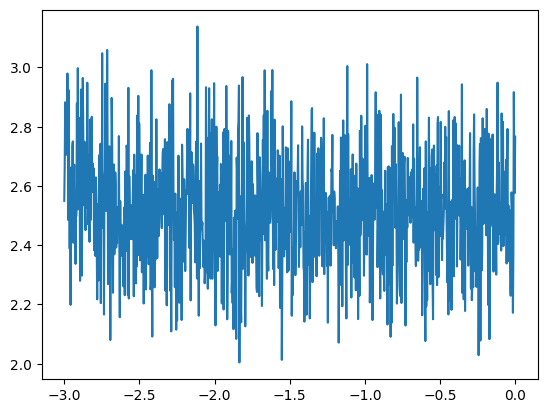

In [75]:
plt.plot(lri, lossi)

## Using the splitting of data into 3 sets

In [31]:
#build the dataset
def build_dataset(words):
    block_size = 2 #context length : how many characters do we take to predict the next one
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size 
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1: ] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 2]) torch.Size([182625])
torch.Size([22655, 2]) torch.Size([22655])
torch.Size([22866, 2]) torch.Size([22866])


In [32]:
C = torch.randn((27,2))

In [33]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 2]), torch.Size([182625]))

In [34]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27, 10, generator = g)
W1 = torch.rand(30, 200, generator = g)
b1 = torch.rand(200, generator = g)
W2 = torch.rand(200, 27, generator = g)
b2 = torch.rand(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [35]:
sum(p.nelement() for p in parameters) 
for p in parameters:
    p.requires_grad = True
lre = torch.linspace(-3, 0, 1000) #This helps in determining a good learning rate
lrs = 10 ** lre #This creates a list of 1000 learning rates from 10^-3 to 10^0.

In [36]:
lri, lossi = [], []
stepi = []
for i in range(200000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0],(32,)) # This creates batches of 32 selected randomly 
    
    # forward pass
    emb = C[X[ix]] #(32,3,2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    # count = logits.exp()
    # prob = count / count.sum(axis = 1, keepdims = True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix]) #This makes both forward and backward pass more efficient and makes number behave better
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    for p in parameters:
        p.data += -0.001*p.grad
        
    #track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    
print(loss.item())

2.8793089389801025


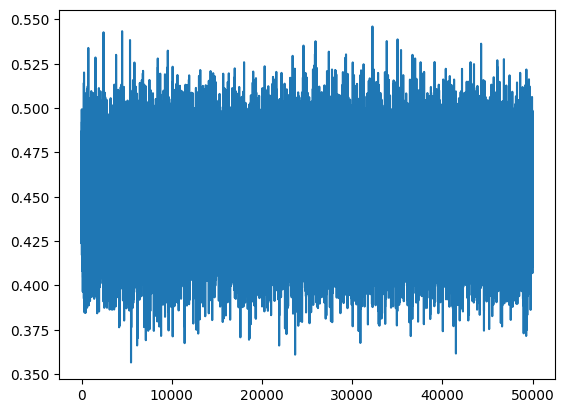

In [164]:
plt.plot(stepi, lossi)

In [166]:
emb = C[Xdev]
h = torch.tanh(emb.view(emb.shape[0],30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.8245, grad_fn=<NllLossBackward0>)

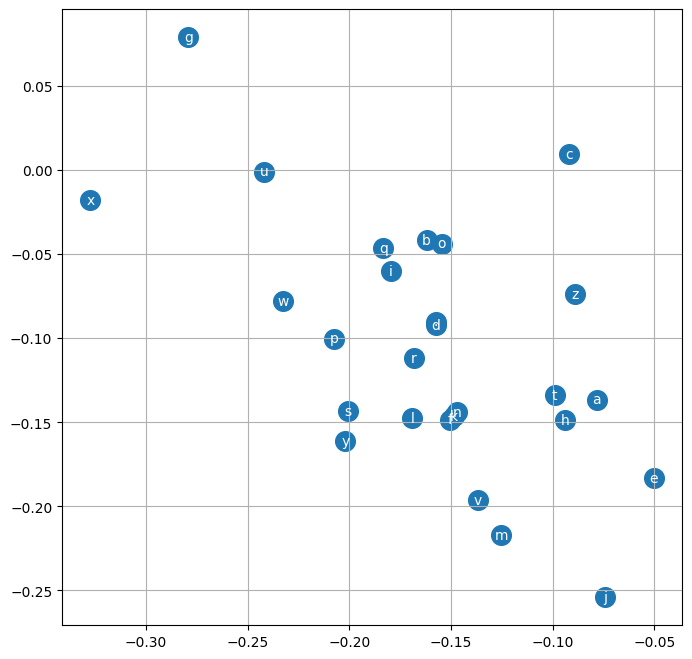

In [148]:
plt.figure(figsize = (8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = 'center', va = 'center', color = 'white')
plt.grid('minor')

In [174]:
#sample generated from code
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1: ] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


narmahxaao.
hlvihkimrs.
reaty.
hncassnejr.
hnenfamesahc.
iaeei.
.
e.
maia.
ceaiivde.
lein.
h.
.
m.
.
oin.
eeijn.
s.
lilea.
.
